## SetUp

In [ ]:
#!pip install pyarrow==12.0.0 --prefer-binary
#!pip install evaluate transformers datasets accelerate==1.9.0 wandb safetensors==0.4.3 --prefer-binary
#!conda install -c conda-forge sentencepiece

In [2]:
#!pip install -q sacrebleu

## Timing performance

In [14]:
import psutil

print("CPU cores:", psutil.cpu_count(logical=True))
print("RAM total:", round(psutil.virtual_memory().total / 1024**3, 2), "GB")

CPU cores: 8
RAM total: 30.99 GB


In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(2)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 1
Corrected: This sentence has bad grammar.
Inference time: 0.782 seconds


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

# ----------- 1. Forcer CPU et nombre de threads -----------
device = torch.device("cpu")
torch.set_num_threads(4)  # Limite PyTorch à 2 CPU
print("Using device:", device)
print("Num threads:", torch.get_num_threads())

# ----------- 2. Charger le modèle et le tokenizer -----------
model_name = "vennify/t5-base-grammar-correction"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ----------- 3. Phrase à corriger -----------
text = "This sentences has has bads grammar."
input_text = "grammar: " + text

# Tokenization
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# ----------- 4. Génération avec mesure du temps -----------
with torch.inference_mode():  # économise la mémoire
    start_time = time.time()
    outputs = model.generate(
        **inputs,
        num_beams=5,
        min_length=1
    )
    end_time = time.time()

# Décodage du texte
corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Corrected:", corrected_text)
print(f"Inference time: {end_time - start_time:.3f} seconds")


Using device: cpu
Num threads: 4
Corrected: This sentence has bad grammar.
Inference time: 0.415 seconds


## Dataset Transform

In [11]:
import pandas as pd
import boto3
bucket_name = 'sagemaker-studio-oxs6vznjds'
key = 'writing_gec/data/writing_corrections.csv'
s3_client = boto3.client('s3', region_name='us-east-1')
obj = s3_client.get_object(Bucket=bucket_name, Key=key)
df = pd.read_csv(obj['Body'])
df = df.dropna(subset=["original_text", "corrected_text"])
#df = df[:5000]  # optional limit rows
print(df.shape)
df.head()

(25202, 46)


,id,student_id,teacher_id,submit_time,submit_writing,correct_time,correct_writing,teacher_comment,grade,template_version,...,original_text,corrected_text,corrected_text_with_tags,corrections,error_types,gpt35_corrected_text,gpt-4o_correction_prompt,gpt4o_batch_correction_id,writing_id,gpt-4o_correction
0,64290636,2e8e5d9d-09df-467a-9661-3fceb5562108,35433534,2024-01-26 06:20:34.077,<input><paragraph>Four years ago we visited Eq...,2024-01-27 00:37:44.297,"<input>Four years ago<code a=""PU"" c="",""></code...","Missing word: ""Four years ago, we visited Equa...",80,18,...,Four years ago we visited Equador and Galapago...,"Four years ago, we visited Equador and the Gal...","Four years ago<code a=""PU"" c="",""></code> we vi...","[{'error_type': 'PU', 'correction': ',', 'writ...","{'WC': 2, 'NSW': 0, 'EX': 0, 'UM': 0, 'SP': 0,...","Four years ago, we visited Ecuador and the Gal...",Correct this text in the style of a language t...,batch_req_m2X9JEvQZtOTaQ5nS8D9AzgE,64290636,"Four years ago, we visited Ecuador and the Gal..."
1,64522003,ef5ee7f9-6e8e-4c82-8ebd-818b48e57d13,35606274,2024-03-06 14:07:30.193,<input><paragraph>I hope this email finds you ...,2024-03-07 09:12:05.380,<input>I hope this email finds you well. I wan...,Verb tense: You have good command over the use...,100,22,...,I hope this email finds you well. I wanted to ...,I hope this email finds you well. I wanted to ...,I hope this email finds you well. I wanted to ...,[],"{'WC': 0, 'NSW': 0, 'EX': 0, 'UM': 0, 'SP': 0,...",I hope this email finds you well. I wanted to ...,Correct this text in the style of a language t...,batch_req_wdVQCiK9zrObJFoY0KW0J2Qk,64522003,I hope this email finds you well. I wanted to ...
2,64328702,b7da77b7-c56d-4628-8e60-d286a9bf9234,21723630,2024-02-08 11:38:48.867,<input><paragraph>I think you could go to an I...,2024-02-10 00:23:23.357,<input>I think you could go to an Italian rest...,Capitalize- Always capitalize the first letter...,90,19,...,I think you could go to an Italian restaurant ...,I think you could go to an Italian restaurant ...,I think you could go to an Italian restaurant<...,"[{'error_type': 'DD', 'correction': '', 'writi...","{'WC': 0, 'NSW': 0, 'EX': 0, 'UM': 0, 'SP': 0,...",I think you could go to an Italian restaurant ...,Correct this text in the style of a language t...,batch_req_z2vLoecWSVsLOl7jzBrUDa5f,64328702,I think you could go to an Italian restaurant ...
3,64411378,02d9e0b7-60b5-4f24-9d06-5b040e8220c3,35700879,2024-02-23 15:45:35.107,"<input><paragraph>Dear Mr. Biggins,</paragraph...",2024-02-24 01:14:36.200,"<input>Dear Mr. Biggins,<code a=""AS"" c="" ""></c...",Punctuation spacing: Please leave a single spa...,95,15,...,"Dear Mr. Biggins,\n\nI hope this email finds y...","Dear Mr. Biggins,\n\nI hope this email finds y...","Dear Mr. Biggins,<code a=""AS"" c="" ""></code>I h...","[{'error_type': 'AS', 'correction': ' ', 'writ...","{'WC': 0, 'NSW': 0, 'EX': 0, 'UM': 0, 'SP': 0,...","Dear Mr. Biggins,\n\nI hope this email finds y...",Correct this text in the style of a language t...,batch_req_0ivyB89xuSedp4VfrzQX4ZJe,64411378,"Dear Mr. Biggins,\n\nI hope this email finds y..."
4,64451515,ea2763c7-83b8-4061-abbd-7a53b30d5fab,28977288,2024-02-28 15:41:52.233,<input><paragraph>Good evening.</paragraph><pa...,2024-02-28 21:57:10.320,"<input>Good evening.<code a=""AS"" c="" ""></code>...",Add Space: Be careful about the use of spaces....,95,25,...,"Good evening.\n\nHow are you?\n\nI'm fine, tha...","Good evening.\n\nHow are you?\n\nI'm fine, tha...","Good evening.<code a=""AS"" c="" ""></code>How are...","[{'error_type': 'AS', 'correction': ' ', 'writ...","{'WC': 0, 'NSW': 0, 'EX': 0, 'UM': 0, 'SP': 0,...","Good evening.\n\nHow are you?\n\nI'm fine, tha...",Correct this text in the style of a language t...,batch_req_wMQiCqOMj3worOWmtWVYLhUJ,64451515,"Good evening. \n\nHow are you? I'm fine, thank..."


In [12]:
df = df[["id", "original_text", "corrected_text"]]
df.head()

,id,original_text,corrected_text
0,64290636,Four years ago we visited Equador and Galapago...,"Four years ago, we visited Equador and the Gal..."
1,64522003,I hope this email finds you well. I wanted to ...,I hope this email finds you well. I wanted to ...
2,64328702,I think you could go to an Italian restaurant ...,I think you could go to an Italian restaurant ...
3,64411378,"Dear Mr. Biggins,\n\nI hope this email finds y...","Dear Mr. Biggins,\n\nI hope this email finds y..."
4,64451515,"Good evening.\n\nHow are you?\n\nI'm fine, tha...","Good evening.\n\nHow are you?\n\nI'm fine, tha..."


In [21]:
from datasets import Dataset, DatasetDict, load_dataset, concatenate_datasets

# Charger le dataset
ds_grammarly = load_dataset("dim/grammarly_coedit")

# Filtrer uniquement les exemples dont la task est 'gec'
ds_grammarly = ds_grammarly["train"].filter(lambda example: example["task"] == "gec")
ds_grammarly = ds_grammarly.remove_columns(["task"])

# Afficher le nombre d'exemples restants
print(ds_grammarly)
print(ds_grammarly[0])

df_hf = df.rename(columns={
    "id": "_id",
    "original_text": "src",
    "corrected_text": "tgt"
})

ds_sft = Dataset.from_pandas(df_hf, preserve_index=False)

df1 = ds_sft.to_pandas()
df2 = ds_grammarly.to_pandas()

def fix(example):
    # Remove the numeric prefix before colon
    string_list = example["src"].split(":")
    text = " ".join(string_list[1:]).strip()
    example["src"] = text
    return example

# Apply the cleaning function
df2 = df2.apply(fix, axis=1)


merged_df = pd.concat([df1, df2], ignore_index=True)
merged_df["_id"] = merged_df["_id"].astype(str)

ds_merged = Dataset.from_pandas(merged_df, preserve_index=False)


split1 = ds_merged.train_test_split(test_size=0.3, seed=42)  # 70% train, 30% remaining
split2 = split1['test'].train_test_split(test_size=0.5, seed=42)  # 15% val, 15% test

ds_ft = DatasetDict({
    "train": split1['train'],
    "validation": split2['train'],
    "test": split2['test']
})

print(ds_ft)


Filter:   0%|          | 0/82466 [00:00<?, ? examples/s]

Dataset({
    features: ['_id', 'src', 'tgt'],
    num_rows: 19823
})
{'_id': '0', 'src': 'Remove all grammatical errors from this text: For example, countries with a lot of deserts can terraform their desert to increase their habitable land and using irrigation to provide clean water to the desert.', 'tgt': 'For example, countries with a lot of deserts can transform their desert to increase their habitable land and use irrigation to provide clean water to the desert.'}
DatasetDict({
    train: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 31517
    })
    validation: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 6754
    })
    test: Dataset({
        features: ['_id', 'src', 'tgt'],
        num_rows: 6754
    })
})


## SFT

In [11]:
MODELNAME = "t5-base"
PREFIX = "grammar: "

In [12]:
import torch
training_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
training_device
import numpy as np

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained(MODELNAME)
model = T5ForConditionalGeneration.from_pretrained(MODELNAME)

In [23]:
print(ds_ft["train"][0])

{'_id': '64677767', 'src': "The aim of this report is to recommend a training company. As you may be aware, the two principal candidates are Skills Pro and Trainquick. In this case Skills Pro is recommended as the preferred training company based on our evaluation. TrainQuick, while offering cost-effective and flexible solutions, falls short due to employee dissatisfaction, particularly regarding mixed-branch classes. \n\nOn the other hand, Skills Pro, though pricier, remains the first choice due to its successful course completion rates and plans for course expansion. Despite the major drawback of higher costs, the quality of training offered by Skills Pro outweighs this chief complaint. \n\nMoreover, Skills Pro's ability to deliver challenging course content, which employees often finish successfully, indicates its effectiveness and suitability for our training needs. Therefore, selecting Skills Pro for our training requirements is a prudent decision, emphasizing the importance of qu

🔤 Max src length: 524
🔤 Max tgt length: 1119
📊 95th percentile src length: 262.0
📊 95th percentile tgt length: 267.0


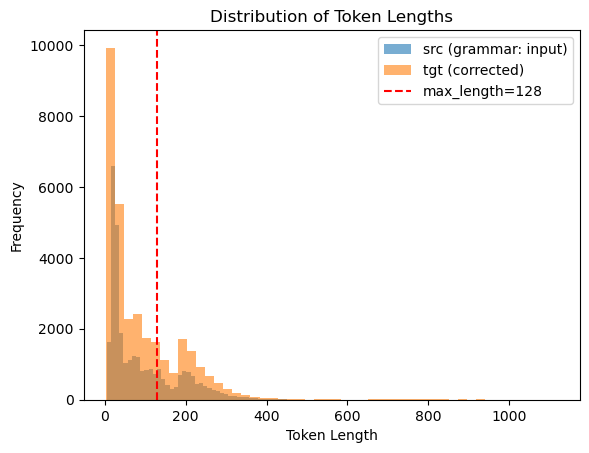

'\n🔤 Max src length: 199\n🔤 Max tgt length: 199\n📊 95th percentile src length: 52.0\n📊 95th percentile tgt length: 49.0\n'

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate lengths
src_lengths = [len(tokenizer.encode("grammar: " + x["src"])) for x in ds_ft["train"]]
tgt_lengths = [len(tokenizer.encode(x["tgt"])) for x in ds_ft["train"]]

# Stats
print(f"🔤 Max src length: {max(src_lengths)}")
print(f"🔤 Max tgt length: {max(tgt_lengths)}")
print(f"📊 95th percentile src length: {np.percentile(src_lengths, 95)}")
print(f"📊 95th percentile tgt length: {np.percentile(tgt_lengths, 95)}")

# Optional: Plot histograms
plt.hist(src_lengths, bins=50, alpha=0.6, label='src (grammar: input)')
plt.hist(tgt_lengths, bins=50, alpha=0.6, label='tgt (corrected)')
plt.axvline(128, color='red', linestyle='--', label='max_length=128')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Token Lengths')
plt.show()

"""
🔤 Max src length: 199
🔤 Max tgt length: 199
📊 95th percentile src length: 52.0
📊 95th percentile tgt length: 49.0
"""

In [25]:
dataset = ds_ft["train"].train_test_split(test_size=0.1, seed=42)
train_ds = ds_ft["train"]
val_ds = ds_ft["validation"]

In [26]:
def preprocess(example):
    input_text = PREFIX + example["src"]
    target_text = example["tgt"]
    model_inputs = tokenizer(input_text, truncation=True, padding="max_length", max_length=256)

    labels = tokenizer(target_text, truncation=True, padding="max_length", max_length=256)
    labels_ids = labels["input_ids"]

    # Important : remplacer les pad_token_id par -100
    labels_ids = [id if id != tokenizer.pad_token_id else -100 for id in labels_ids]

    model_inputs["labels"] = labels_ids
    return model_inputs


tokenized_train = train_ds.map(preprocess, batched=False)
tokenized_val = val_ds.map(preprocess, batched=False)

Parameter 'function'=<function preprocess at 0x7fe7bbf33eb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/31517 [00:00<?, ? examples/s]

Map:   0%|          | 0/6754 [00:00<?, ? examples/s]

In [27]:
import evaluate
import sacrebleu
import numpy as np

exact_match = evaluate.load("exact_match")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # predictions peuvent contenir des IDs invalides → clip
    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Exact match
    em = exact_match.compute(predictions=decoded_preds, references=decoded_labels)["exact_match"]

    # BLEU via sacrebleu
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    bleu_score = bleu.score

    return {"exact_match": em, "bleu": bleu_score}


In [ ]:
import torch
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-grammar-corrector",
    do_eval=True,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,                             # The model to train
    args=training_args,                      # Training configurations
    train_dataset=tokenized_train,           # Tokenized training data
    eval_dataset=tokenized_val,              # Tokenized validation data
    tokenizer=tokenizer,                     # Tokenizer (for padding, decoding, etc.)
)

trainer.train()

"""
Epoch Training Loss Validation Loss
1 0.185000 0.165196
2 0.178100 0.161055
3 0.171300 0.160168
TrainOutput(global_step=27834, training_loss=0.1946344326956995, metrics={'train_runtime': 2212.8832, 'train_samples_per_second': 100.619, 'train_steps_per_second': 12.578, 'total_flos': 7533699872587776.0, 'train_loss': 0.1946344326956995, 'epoch': 3.0})
"""

In [33]:
model.save_pretrained("./t5-grammar-corrector")
tokenizer.save_pretrained("./t5-grammar-corrector")

"""
('./t5-grammar-corrector/tokenizer_config.json',
 './t5-grammar-corrector/special_tokens_map.json',
 './t5-grammar-corrector/spiece.model',
 './t5-grammar-corrector/added_tokens.json')
"""

"\n('./t5-grammar-corrector/tokenizer_config.json',\n './t5-grammar-corrector/special_tokens_map.json',\n './t5-grammar-corrector/spiece.model',\n './t5-grammar-corrector/added_tokens.json')\n"

In [34]:
eval_results = trainer.evaluate()
print("📊 Evaluation Results:", eval_results)

""" 
[1031/1031 00:25]
📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}
"""

📊 Evaluation Results: {'eval_loss': 0.34969887137413025, 'eval_runtime': 1.2431, 'eval_samples_per_second': 120.663, 'eval_steps_per_second': 15.284, 'epoch': 3.0}


" \n[1031/1031 00:25]\n📊 Evaluation Results: {'eval_loss': 0.1601683497428894, 'eval_runtime': 25.8443, 'eval_samples_per_second': 319.104, 'eval_steps_per_second': 39.893, 'epoch': 3.0}\n"

## Inference 

In [43]:
model = T5ForConditionalGeneration.from_pretrained("./t5-grammar-corrector/checkpoint-3500/")
tokenizer = T5Tokenizer.from_pretrained("./t5-grammar-corrector")

def correct_grammar(text: str):
    input_text = f"grammar: {text}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    # Move to GPU if available
    input_ids = input_ids.to(model.device)

    output_ids = model.generate(input_ids, max_length=256, num_beams=4)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

"""

❌ Original:  He go to school every day.
✅ Corrected: He goes to school every day.
"""

'\n\n❌ Original:  He go to school every day.\n✅ Corrected: He goes to school every day.\n'

In [53]:
# Try on a sample sentence
test_sentence = '''
"Dear Team,

I want to take a moment to express my deepest gratitude for all the hard work, dedication, and passion you bring to our organization every day. Each of you plays an integral role in our success, and I couldn't be prouder of the incredible strides we've made together.

This year has been filled with challenges, but your resilience and determination have turned those challenges into opportunities. Your creativity and teamwork continue to drive innovation, and it's because of your efforts that we’ve been able to achieve so much. Every project completed, every client satisfied, and every goal met is a testament to your commitment and talent.

As we look toward the future, I encourage you to stay motivated and keep believing in your abilities. Remember, no contribution is too small; together, we create something much greater than ourselves. If ever you feel overwhelmed, lean on your teammates, and don’t hesitate to share your ideas or concerns. We grow stronger by supporting each other.

Let’s continue to set new benchmarks and achieve even greater heights. Your work matters, your ideas matter, and most importantly, you matter. Thank you for being an essential part of this journey. Keep pushing forward—you are truly unstoppable!"
'''

corrected = correct_grammar(test_sentence)
print(f"\n❌ Original:  {test_sentence}")
print(f"✅ Corrected: {corrected}")



❌ Original:  
"Dear Team,

I want to take a moment to express my deepest gratitude for all the hard work, dedication, and passion you bring to our organization every day. Each of you plays an integral role in our success, and I couldn't be prouder of the incredible strides we've made together.

This year has been filled with challenges, but your resilience and determination have turned those challenges into opportunities. Your creativity and teamwork continue to drive innovation, and it's because of your efforts that we’ve been able to achieve so much. Every project completed, every client satisfied, and every goal met is a testament to your commitment and talent.

As we look toward the future, I encourage you to stay motivated and keep believing in your abilities. Remember, no contribution is too small; together, we create something much greater than ourselves. If ever you feel overwhelmed, lean on your teammates, and don’t hesitate to share your ideas or concerns. We grow stronger b

## Evaluation F0-5

In [10]:
## to do use errant locally https://github.com/chrisjbryant/errant